In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,GridSearchCV,cross_validate
import sklearn.metrics as metrics 
import matplotlib.cm as cm

# algorithms
import xgboost as xgb
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")

# metrics
from sklearn.metrics import mean_squared_error, r2_score ,explained_variance_score


In [2]:
df = pd.read_excel("/Users/zaferavci/Documents/GitHub/Miuul-CaseStudy-1/Miuul-Case-Study/oppurtunity.xlsx", header=0) 

In [3]:
df.columns = [col.lower() for col in df.columns]

In [4]:
df.head()

,opp. id,contactid,recordtype.name,account.name,amount,platform__c,closedate,donation_date__c,stagename,campaign.name
0,0065G00000WOEXGQA5,NaN,Expansion Income,`3613,200.0,NaN,2020-10-22,NaT,Awarded,NaN
1,0065G00000WOEdEQAX,003f400000GtceBAAR,Silent Auction Purchase,`5059,2550.0,NaN,2020-06-30,NaT,Closed Won,2020 EWC
2,0065G00000WOEf0QAH,003f400001IklhmAAB,Donation,`0211,50.0,Facebook,2020-10-12,NaT,Closed Won,NaN
3,0065G00000WOEf1QAH,0035G00001aanl2QAA,Donation,`0219,80.0,Facebook,2020-10-16,NaT,Closed Won,NaN
4,0065G00000WOEf2QAH,0035G00001aanl3QAA,Donation,`0277,10.0,Facebook,2020-10-15,NaT,Closed Won,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   opp. id           16000 non-null  object        
 1   contactid         15069 non-null  object        
 2   recordtype.name   16000 non-null  object        
 3   account.name      15996 non-null  object        
 4   amount            15618 non-null  float64       
 5   platform__c       13849 non-null  object        
 6   closedate         16000 non-null  datetime64[ns]
 7   donation_date__c  7557 non-null   datetime64[ns]
 8   stagename         16000 non-null  object        
 9   campaign.name     12503 non-null  object        
dtypes: datetime64[ns](2), float64(1), object(7)
memory usage: 1.2+ MB


In [6]:
df.isnull().sum()

opp. id                0
contactid            931
recordtype.name        0
account.name           4
amount               382
platform__c         2151
closedate              0
donation_date__c    8443
stagename              0
campaign.name       3497
dtype: int64

In [7]:
# Eksik değerlerin sayısı ve yüzdesi
missing_df = df.isnull().sum().to_frame(name='Missing Count')
missing_df['Missing Ratio (%)'] = 100 * missing_df['Missing Count'] / len(df)
missing_df = missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False)


In [8]:
missing_df

,Missing Count,Missing Ratio (%)
donation_date__c,8443,52.76875
campaign.name,3497,21.85625
platform__c,2151,13.44375
contactid,931,5.81875
amount,382,2.38750
account.name,4,0.02500


Missing Valueların Doldurulması

In [9]:
# 1. 'donation_date__c' kolonunu tamamen sil
df.drop(columns=['donation_date__c'], inplace=True)

In [10]:
# 2. 'campaign.name' eksiklerini 'No campaign' ile doldur
df['campaign.name'] = df['campaign.name'].fillna('No campaign')

In [11]:
# 3. 'contactid' ve 'account.name' boş olan satırları sil
df.dropna(subset=['contactid', 'account.name'], inplace=True)

In [12]:
# 4. 'amount' eksiklerini medyan ile doldur
df['amount'] = df['amount'].fillna(df['amount'].median())

Platform_c nin Campaign name ilişkisine göre koşullu mod ile doldurulması

In [13]:
# Adım 1: Kırılma noktasını düzeltiyoruz – to_frame'e özel isim veriyoruz
campaign_platform_ratio = (
    df[df['platform__c'].notnull()]
    .groupby(['campaign.name', 'platform__c'])
    .size()
    .reset_index(name='count')  # Bu artık tekrar etmeyen isim olacak
)

# Adım 2: Toplam kampanya sayısına göre oranları hesapla
total_counts = campaign_platform_ratio.groupby('campaign.name')['count'].transform('sum')
campaign_platform_ratio['ratio'] = campaign_platform_ratio['count'] / total_counts

In [14]:
campaign_platform_ratio.sort_values(by="count", ascending=False)

,campaign.name,platform__c,count,ratio
387,No campaign,Facebook,1260,0.514496
104,2023 EKC,PledgeIt,708,0.960651
359,Every Kick Counts 2022,PledgeIt,631,0.954614
377,Lydie's Loop 2022,Qgiv,543,0.985481
380,No campaign,CTK Website,531,0.216823
...,...,...,...,...
270,2024 Indy Community Baby Shower,Check,1,1.000000
111,2023 EKC Golf Tournament Silent Auction,HBD Website,1,1.000000
278,2024 Lydie's Loop Donations,HBD Website,1,0.002681
61,2022 EWC Table Captains,Give Lively,1,0.025641


In [15]:
# %90 üzeri eşleşmeleri al
strong_matches = campaign_platform_ratio[campaign_platform_ratio['ratio'] >= 0.9]

# Sözlük oluştur: {'Campaign.Name': 'Platform__c'}
campaign_to_platform = dict(zip(strong_matches['campaign.name'], strong_matches['platform__c']))

In [16]:
campaign_to_platform

{'10 for 10': 'Facebook',
 '2019 Summer Event': 'Check',
 '2020 Thank You': 'CTK Website',
 '2021 EWC Peer-to-Peer': 'Qgiv',
 '2021 EWC Reminder Postcard 4.26.21': 'Qgiv',
 '2021 EWC Table Captains': 'Qgiv',
 '2021 EWC Text to Give': 'Give Lively',
 '2022 EWC Board Pledges': 'Check',
 '2022 Giving Tuesday | Together We Count': 'Facebook',
 '2022 HBD Birthday Campaign': 'Give Lively',
 '2022 HBD Birthday Campgian': 'Give Lively',
 '2022 Honoring CJ': 'Give Lively',
 '2022 Kendra Scott Giveback Event': 'Check',
 '2023 CM In Person Ticket': 'FundEasy',
 '2023 CM Silent Auction': 'Square',
 '2023 EKC': 'PledgeIt',
 '2023 EKC Golf Tournament Foursome': 'FundEasy',
 '2023 EKC Golf Tournament In-Kind Donors': 'Check',
 '2023 EKC Golf Tournament Silent Auction': 'HBD Website',
 '2023 Gamechangers': 'PledgeIt',
 "2023 Lydie's Loop Donations": 'Qgiv',
 "2023 Lydie's Loop Registration": 'Qgiv',
 '2023 MCH Symposium Exhibitor': 'CTK Website',
 '2023 Walk of Remembrance': 'Qgiv',
 '2023 Walk of Rem

In [17]:
from tqdm import tqdm

for i in tqdm(df[df['platform__c'].isnull()].index):

    campaign = df.loc[i, 'campaign.name']
    recordtype = df.loc[i, 'recordtype.name']

    # 1. Kampanyaya göre doldur
    if campaign in campaign_to_platform:
        df.at[i, 'platform__c'] = campaign_to_platform[campaign]

    # 2. Kampanya eşleşmedi, record type'a göre mod
    elif pd.notnull(recordtype):
        platform_mode = df[df['recordtype.name'] == recordtype]['platform__c'].mode()
        if not platform_mode.empty:
            df.at[i, 'platform__c'] = platform_mode[0]

    # 3. Hiçbir şey yoksa genel mod
    else:
        overall_mode = df['platform__c'].mode()
        if not overall_mode.empty:
            df.at[i, 'platform__c'] = overall_mode[0]

100%|██████████████████████████████████████| 1853/1853 [00:01<00:00, 984.48it/s]


In [18]:
df.isnull().sum()

opp. id            0
contactid          0
recordtype.name    0
account.name       0
amount             0
platform__c        0
closedate          0
stagename          0
campaign.name      0
dtype: int64

In [19]:
# İlk olarak tüm object ve category kolonlarını al
cat_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

# ID gibi analizde kullanmak istemediğimiz kolonları çıkar
id_cols = ['opp. id', 'contactid', 'account.name']
cat_cols = [col for col in cat_cols if col not in id_cols]

# Sayısal kolonlar
num_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Tarih kolonları
date_cols = df.select_dtypes(include=['datetime']).columns.tolist()

# Sonuçları görelim
print("Kategorik Değişkenler:", cat_cols)
print("Sayısal Değişkenler:", num_cols)
print("Tarih Değişkenleri:", date_cols)

Kategorik Değişkenler: ['recordtype.name', 'platform__c', 'stagename', 'campaign.name']
Sayısal Değişkenler: ['amount']
Tarih Değişkenleri: ['closedate']


Kategorik Değişkenler

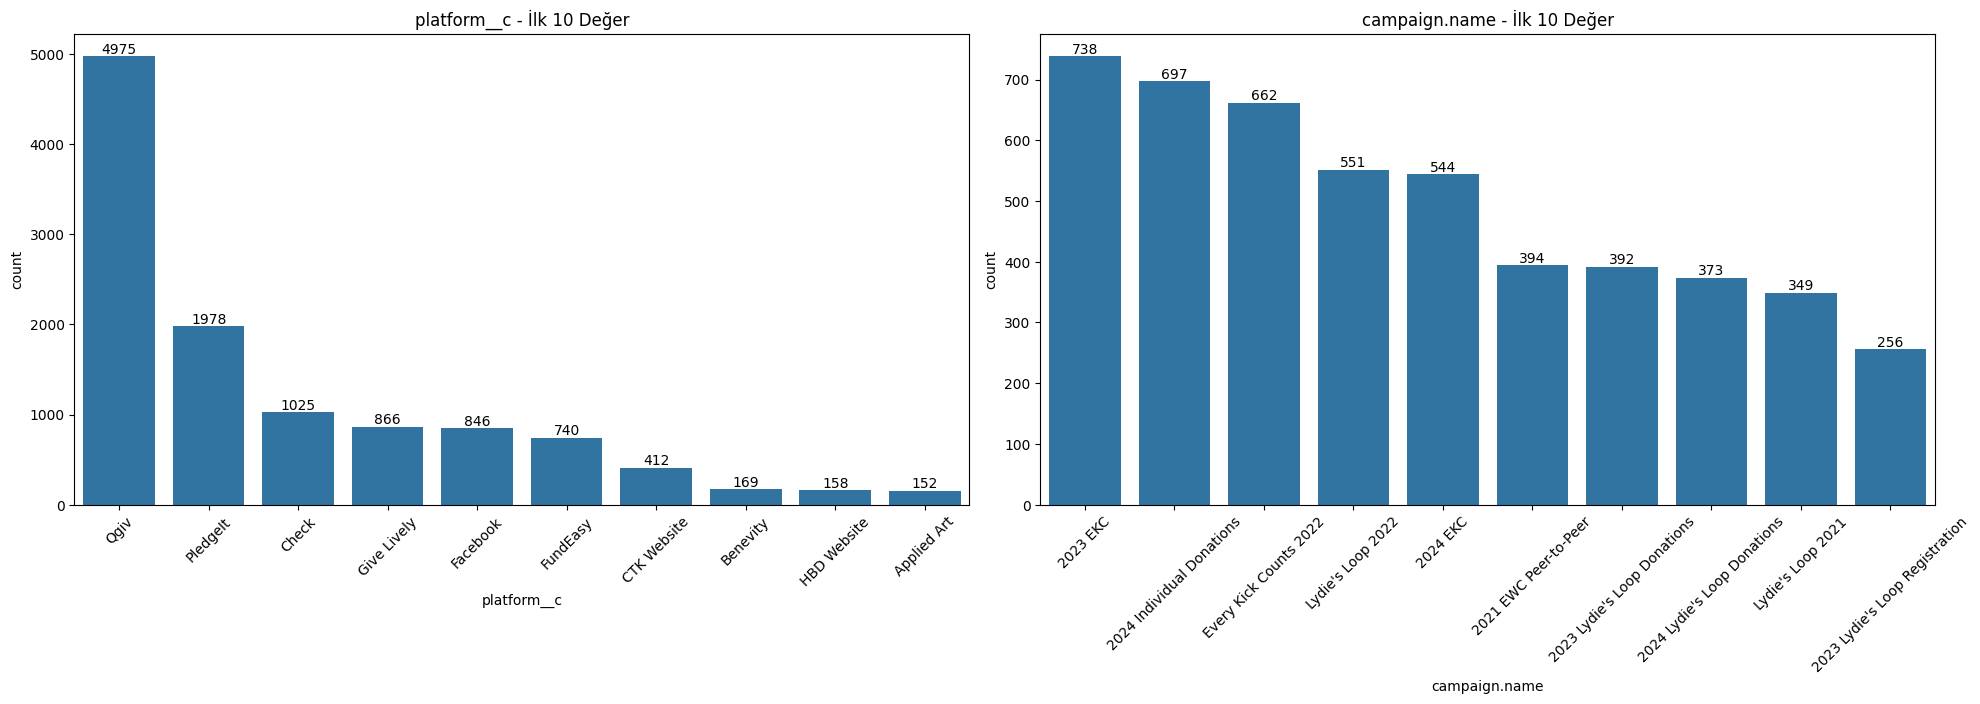

In [70]:
cat_cols = ['platform__c', 'campaign.name']

# No campaign'i filtrele
df_filtered = df[df['campaign.name'] != 'No campaign']

plt.figure(figsize=(20, 12))
for i, col in enumerate(cat_cols):
    plt.subplot(2, 2, i + 1)
    # En çok görülen 10 kategori (No campaign hariç)
    order = df_filtered[col].value_counts().head(10).index  
    ax = sns.countplot(data=df_filtered, x=col, order=order)
    plt.title(f"{col} - İlk 10 Değer")
    plt.xticks(rotation=45)
    
    # Sütunlara değer etiketlerini ekle
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)

plt.tight_layout()
plt.savefig("grafik_no_campaign_filtered.png", dpi=300)
plt.show()

Sayısal Değişken

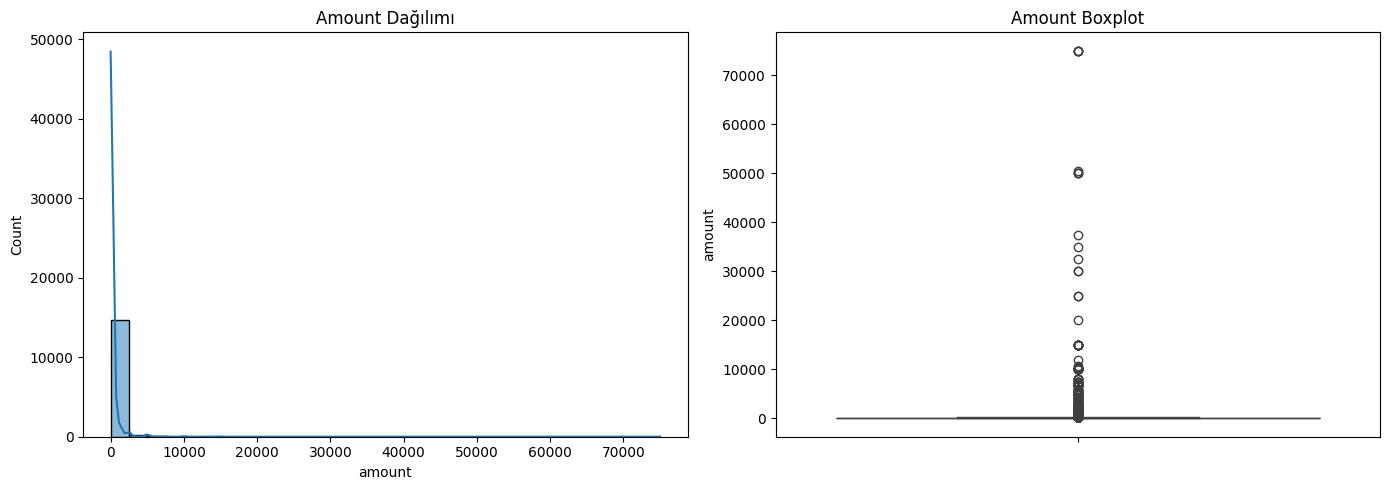

In [21]:
plt.figure(figsize=(14, 5))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(df['amount'], kde=True, bins=30)
plt.title("Amount Dağılımı")

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data=df, y='amount')
plt.title("Amount Boxplot")

plt.tight_layout()
plt.show()


In [22]:
def calculate_LB_UB (df,var):
    '''calculating upper bound and lower bound values to identify outliers'''
    Q3=np.percentile(df[var],75)
    Q1=np.percentile(df[var],25)
    IQR=1.5*(Q3-Q1)
    
    UB=Q3+IQR
    LB=Q1-IQR
    
    print(LB,UB)
    
    return LB,UB

In [23]:
#numerical_columns = df.select_dtypes('float64', 'int').columns

for i in num_cols:
    print("\n name of column:", i)
    LB, UB = calculate_LB_UB(df, i)
    print("min and max value", (df[i].min(), df[i].max()))
    print("range of outliers:", LB, UB)
    
    if df[i].max() > UB or df[i].min() < LB:
        print("----Investigate variable for outliers---")


 name of column: amount
-87.5 212.5
min and max value (np.float64(0.0), np.float64(75000.0))
range of outliers: -87.5 212.5
----Investigate variable for outliers---


Zaman Serisi Analizleri

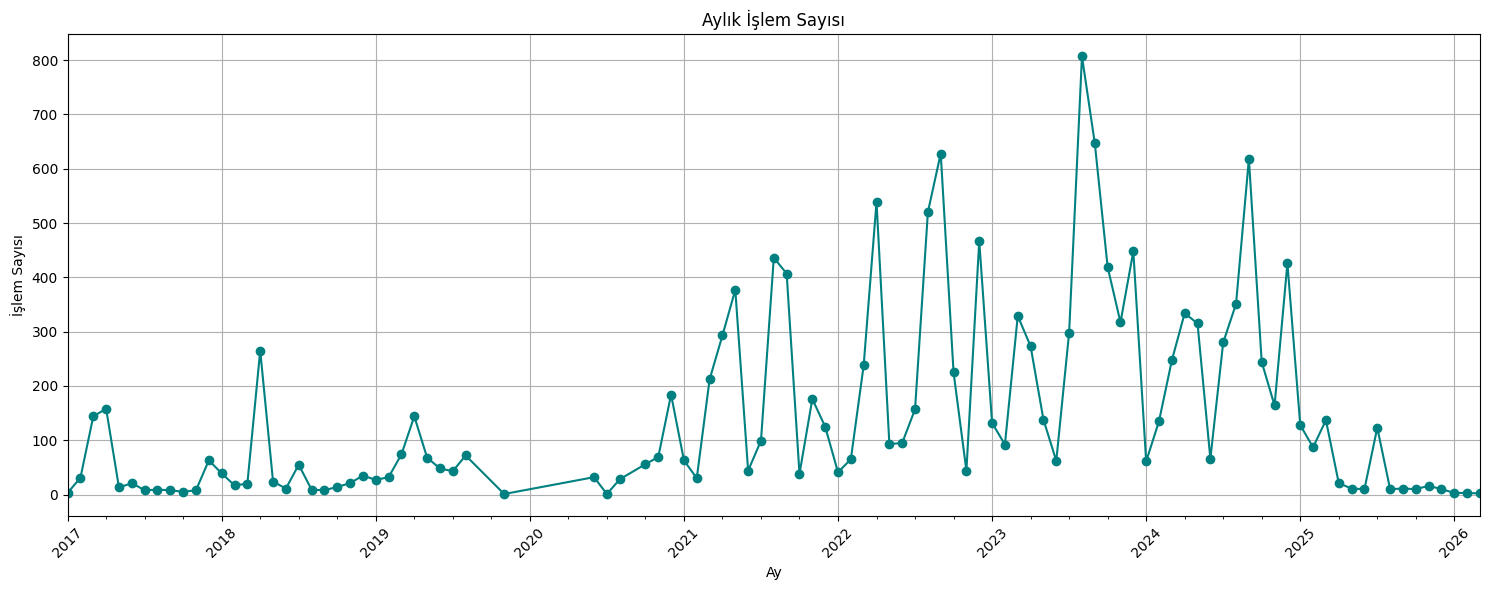

In [24]:
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

monthly_closed = df.groupby(df['closedate'].dt.to_period("M")).size()

plt.figure(figsize=(15, 6))
monthly_closed.plot(kind='line', marker='o', color='teal')
plt.title("Aylık İşlem Sayısı")
plt.xlabel("Ay")
plt.ylabel("İşlem Sayısı")
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("aylıkişlem.png", dpi=300)
plt.show()
monthly_closed.to_excel("monthly.xlsx")


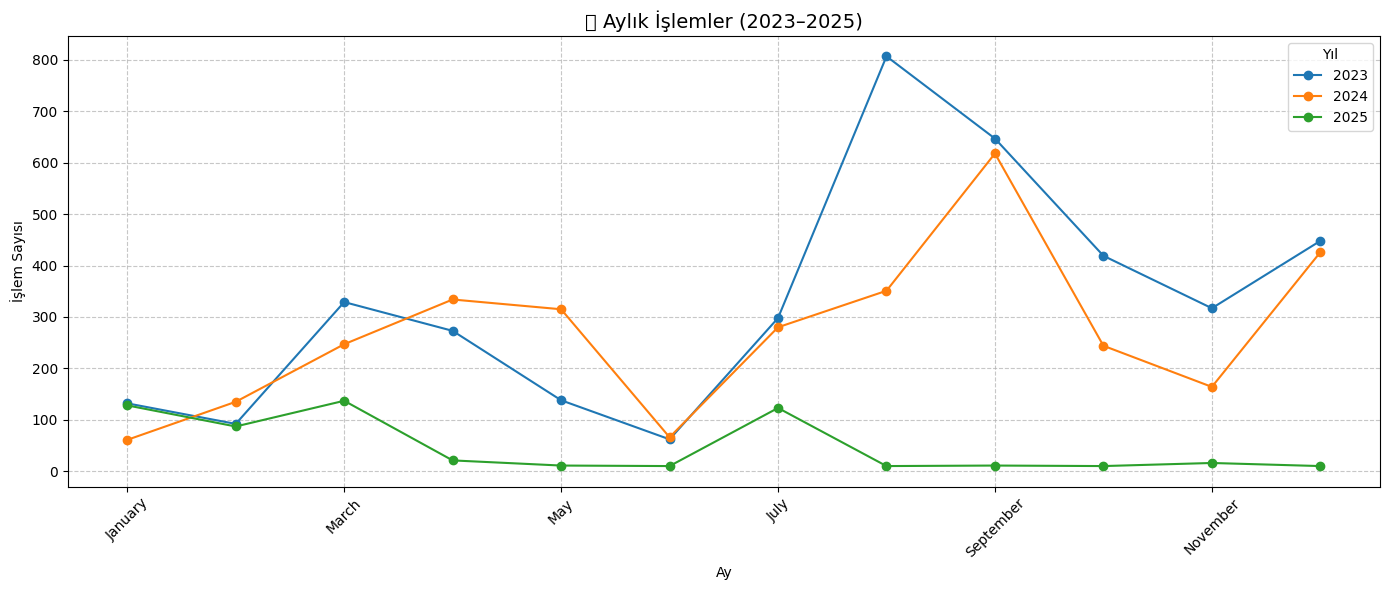

In [25]:
# closedate'i datetime formatına çevir
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

# Yıl ve ay kolonlarını çıkar
df['year'] = df['closedate'].dt.year
df['month'] = df['closedate'].dt.month_name()

# Sadece 2023-2025 yıllarını filtrele
filtered = df[df['year'].isin([2023, 2024, 2025])]

# Ay sıralaması için sabit liste
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Pivot tablo: yıl-ay bazlı sayılar
monthly_by_year = (
    filtered.groupby(['year', 'month'])
    .size()
    .reset_index(name='count')
    .pivot(index='month', columns='year', values='count')
    .reindex(month_order)  # ay sırasına göre düzenle
)

# Çizgi grafiği
monthly_by_year.plot(kind='line', marker='o', figsize=(14, 6))
plt.title("📈 Aylık İşlemler (2023–2025)", fontsize=14)
plt.xlabel("Ay")
plt.ylabel("İşlem Sayısı")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Yıl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("yıllıkişlem23-25.png", dpi=300)
plt.show()

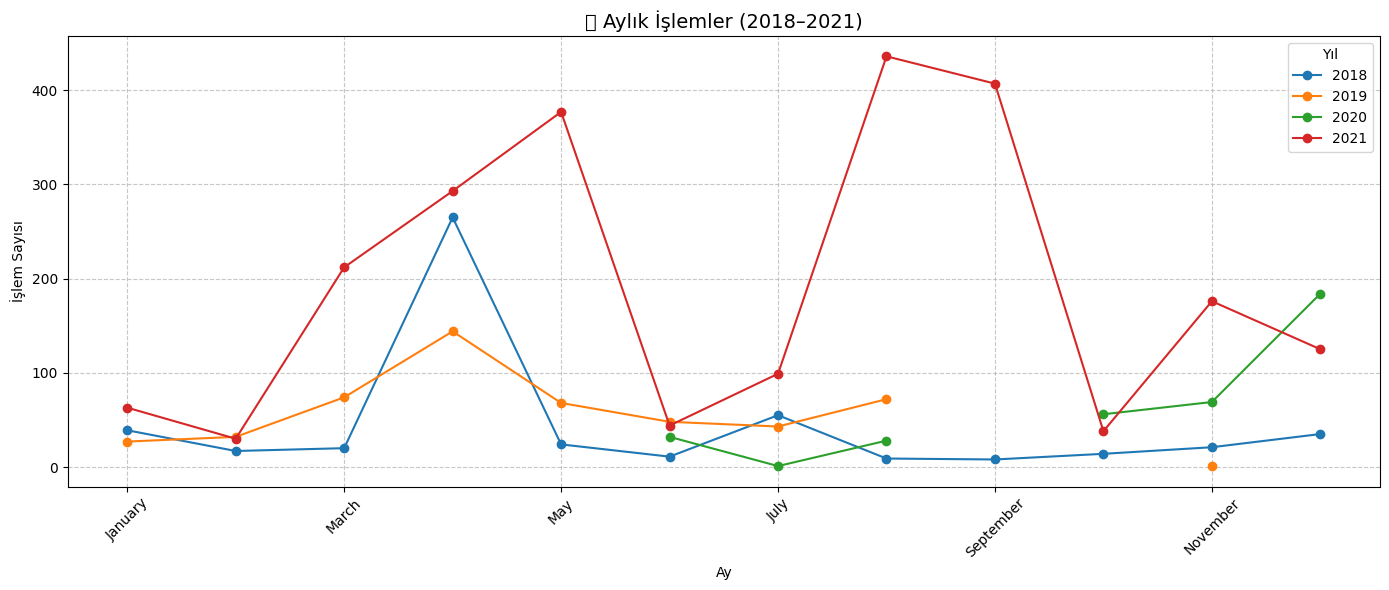

In [26]:

# Sadece 2023-2025 yıllarını filtrele
filtered = df[df['year'].isin([2018, 2019, 2020, 2021])]

# Ay sıralaması için sabit liste
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

# Pivot tablo: yıl-ay bazlı sayılar
monthly_by_year = (
    filtered.groupby(['year', 'month'])
    .size()
    .reset_index(name='count')
    .pivot(index='month', columns='year', values='count')
    .reindex(month_order)  # ay sırasına göre düzenle
)

# Çizgi grafiği
monthly_by_year.plot(kind='line', marker='o', figsize=(14, 6))
plt.title("📈 Aylık İşlemler (2018–2021)", fontsize=14)
plt.xlabel("Ay")
plt.ylabel("İşlem Sayısı")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title="Yıl")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("yıllıkişlem18-21.png", dpi=300)
plt.show()

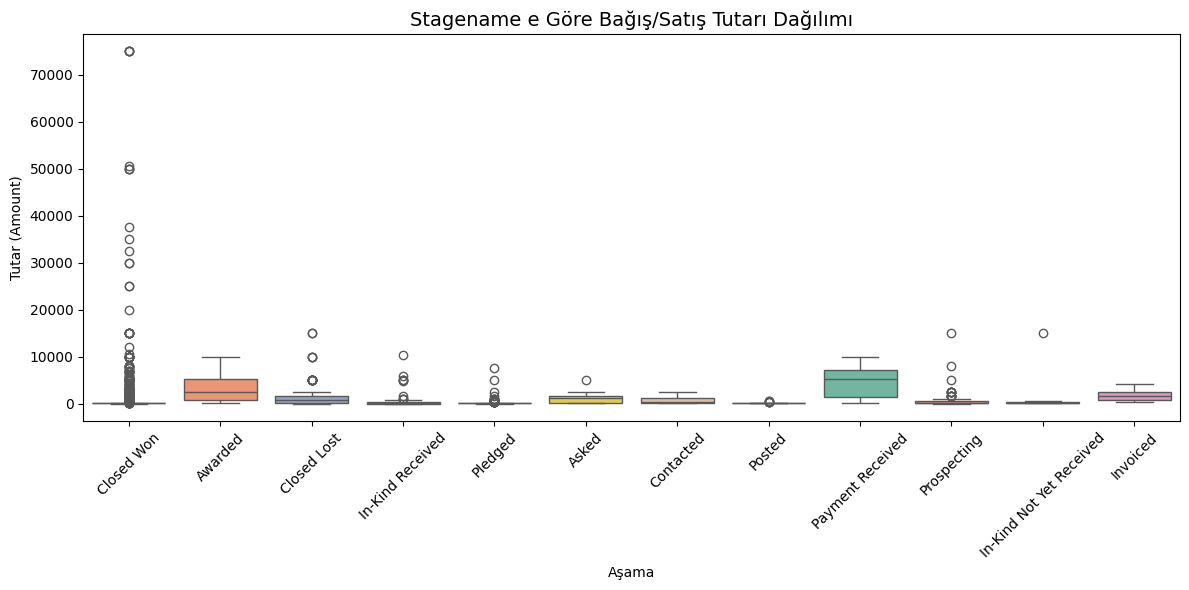

In [27]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='stagename', y='amount', palette='Set2')
plt.title("Stagename e Göre Bağış/Satış Tutarı Dağılımı", fontsize=14)
plt.xlabel("Aşama")
plt.ylabel("Tutar (Amount)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [28]:
stage_amount_avg = df.groupby('stagename')['amount'].agg(['count', 'mean', 'median']).sort_values('count', ascending=False)
stage_amount_avg = stage_amount_avg.reset_index()
stage_amount_avg

,stagename,count,mean,median
0,Closed Won,14287,250.197866,50.0
1,Pledged,234,176.906923,50.4
2,Closed Lost,223,1339.649462,750.0
3,Prospecting,131,636.236565,200.0
4,In-Kind Received,65,692.276923,50.0
5,Asked,50,1078.000000,1125.0
6,Posted,27,119.708889,75.0
7,Invoiced,15,1708.333333,1500.0
8,Awarded,11,3651.818182,2500.0
9,Payment Received,10,4860.000000,5250.0


=== Platform Bazlı Tutar Özeti ===
                           count       total         mean   median
platform__c                                                       
Qgiv                        5481  1352396.15   246.742593    50.00
Facebook                    2106   124322.24    59.032403    25.00
PledgeIt                    1999   174259.66    87.173417    50.00
Check                       1200  1271682.00  1059.735000   250.00
CTK Website                  943   140167.30   148.639767    50.00
Give Lively                  936   102078.49   109.058216    50.00
FundEasy                     741   185869.65   250.836235   103.20
Benevity                     335    52679.55   157.252388    20.00
HBD Website                  184    31855.00   173.125000    50.00
Applied Art                  152    38270.00   251.776316    75.00
United Way                   146    35043.28   240.022466    57.32
Frontstream                  125    62231.38   497.851040   416.67
Direct Deposit             

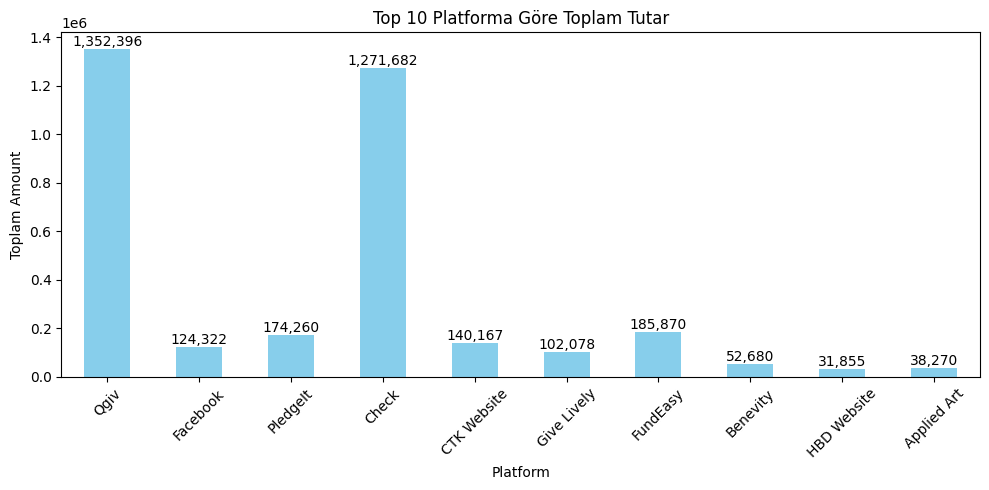

In [29]:
# 2.1 Platform Bazlı Tutar Analizi
# —————————————————————————————————————————————
platform_amount = df.groupby('platform__c')['amount'].agg(
    count='count',
    total='sum',
    mean='mean',
    median='median'
).sort_values('count', ascending=False)

print("=== Platform Bazlı Tutar Özeti ===")
print(platform_amount)

# Bar chart: Platform bazlı toplam tutar
# İlk 10 platformu al
top10_platforms = platform_amount.head(10)

# Grafik
plt.figure(figsize=(10,5))
ax = top10_platforms['total'].plot(kind='bar', color='skyblue')

plt.title("Top 10 Platforma Göre Toplam Tutar")
plt.xlabel("Platform")
plt.ylabel("Toplam Amount")
plt.xticks(rotation=45)

# Sütunlara değer etiketlerini ekle
for i, value in enumerate(top10_platforms['total']):
    ax.text(i, value, f'{value:,.0f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig("top10platformamunt.png", dpi=300)
plt.show()




=== En Yoğun 10 Kampanya Bazlı Tutar Özeti ===
                             count     total        mean  median
campaign.name                                                   
2023 EKC                       738  72676.70   98.477913   50.00
2024 Individual Donations      697  84183.71  120.780072   26.01
Every Kick Counts 2022         662  64250.91   97.055755   50.00
Lydie's Loop 2022              551  36026.50   65.383848   40.00
2024 EKC                       544  58536.89  107.604577   50.00
2021 EWC Peer-to-Peer          394  59678.25  151.467640   63.00
2023 Lydie's Loop Donations    392  23936.15   61.061607   50.00
2024 Lydie's Loop Donations    373  22656.06   60.740107   50.00
Lydie's Loop 2021              349  24124.60   69.124928   40.00


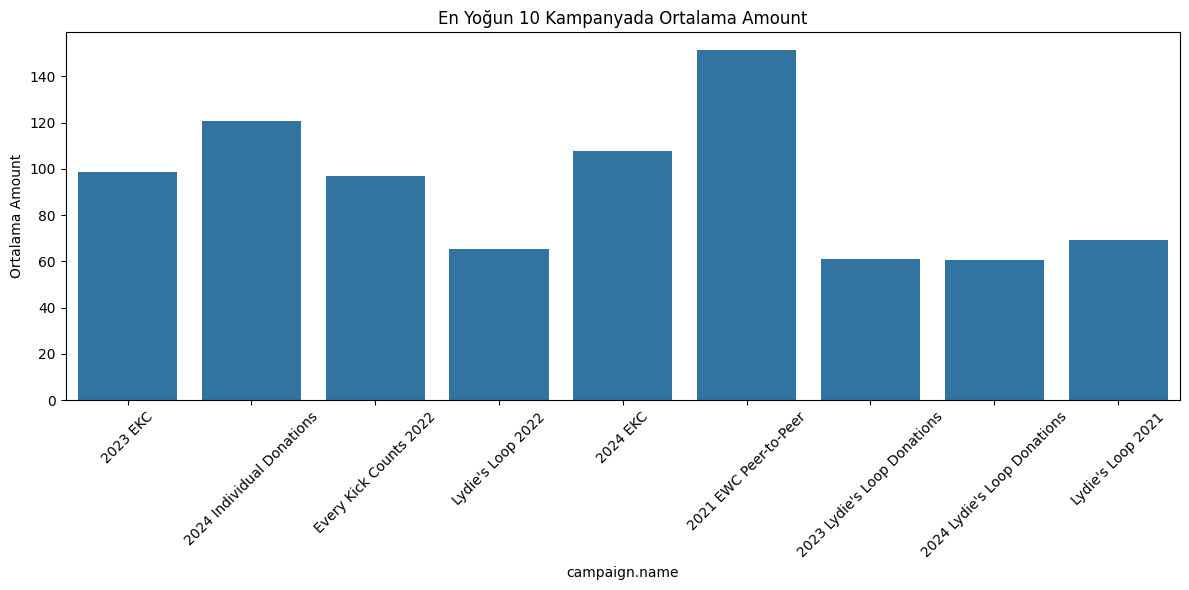

In [30]:
# 2.2 Kampanya Bazlı Tutar Analizi (İlk 10 Kampanya)
# —————————————————————————————————————————————
top_campaigns = df['campaign.name'].value_counts().head(10).index
campaign_amount = df[df['campaign.name'].isin(top_campaigns)].groupby('campaign.name')['amount'].agg(
    count='count',
    total ='sum',
    mean='mean',
    median='median'
).sort_values('count', ascending=False)

campaign_amount = campaign_amount.drop("No campaign")

print("\n=== En Yoğun 10 Kampanya Bazlı Tutar Özeti ===")
print(campaign_amount)

plt.figure(figsize=(12,6))
sns.barplot(
    data=campaign_amount.reset_index(),
    x='campaign.name', y='mean',
    order=campaign_amount.index
)
plt.title("En Yoğun 10 Kampanyada Ortalama Amount")
plt.xlabel("campaign.name")
plt.ylabel("Ortalama Amount")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



PLATFORM BAZLI BAŞARI ORANI

=== Platform Başarı Oranları (%) ===
                           total   won    win_rate
platform__c                                       
YourCause                     47    47  100.000000
Grateful                       1     1  100.000000
Benevity                     335   335  100.000000
United Way                   146   146  100.000000
Truist                        63    63  100.000000
Community Foundation          45    45  100.000000
Cybergrants - CAF America     41    41  100.000000
Cybergrants - Nationwide      34    34  100.000000
Pledge.com                    16    16  100.000000
Frontstream                  125   125  100.000000
Applied Art                  152   152  100.000000
Facebook                    2106  2103   99.857550
Venmo                        111   110   99.099099
32Auctions                    57    56   98.245614
Instagram                     47    46   97.872340
CTK Website                  943   920   97.560976
Qgiv                        5481  5213   95.1

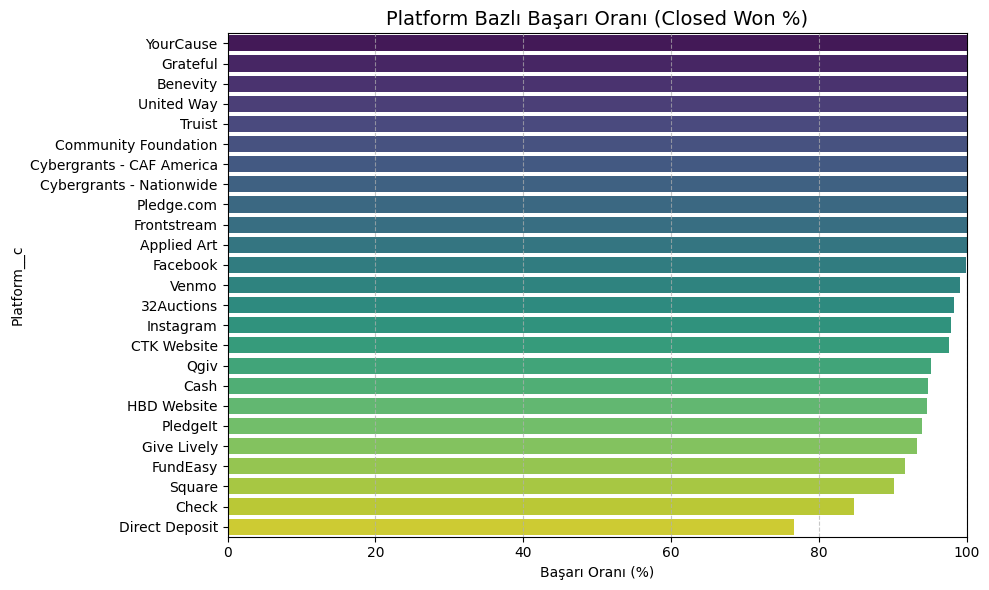

In [31]:
# 1. Kolon adlarını küçült ve stagename değerlerini normalize et
df.columns = df.columns.str.strip().str.lower()
df['stagename'] = df['stagename'].str.strip().str.lower()

# 2. Platform bazlı toplam fırsat sayısı
platform_totals = df.groupby('platform__c').size().rename('total')

# 3. “closed won” olarak işaretlenmiş fırsat sayısı
platform_won = (
    df[df['stagename'] == 'closed won']
    .groupby('platform__c')
    .size()
    .rename('won')
)

# 4. Win rate hesapla
platform_perf = pd.concat([platform_totals, platform_won], axis=1).fillna(0)
platform_perf['win_rate'] = platform_perf['won'] / platform_perf['total'] * 100

# 5. Sonuçları tablo olarak yazdır
print("=== Platform Başarı Oranları (%) ===")
print(platform_perf.sort_values('win_rate', ascending=False)[['total','won','win_rate']])

# 6. Bar chart ile görselleştir
plt.figure(figsize=(10,6))
order = platform_perf.sort_values('win_rate', ascending=False).index
sns.barplot(
    x=platform_perf.loc[order, 'win_rate'],
    y=order,
    palette='viridis'
)
plt.title("Platform Bazlı Başarı Oranı (Closed Won %)", fontsize=14)
plt.xlabel("Başarı Oranı (%)")
plt.ylabel("Platform__c")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

HAFTALIK VE AYLIK STAGE WON LOST TRENDLERİ

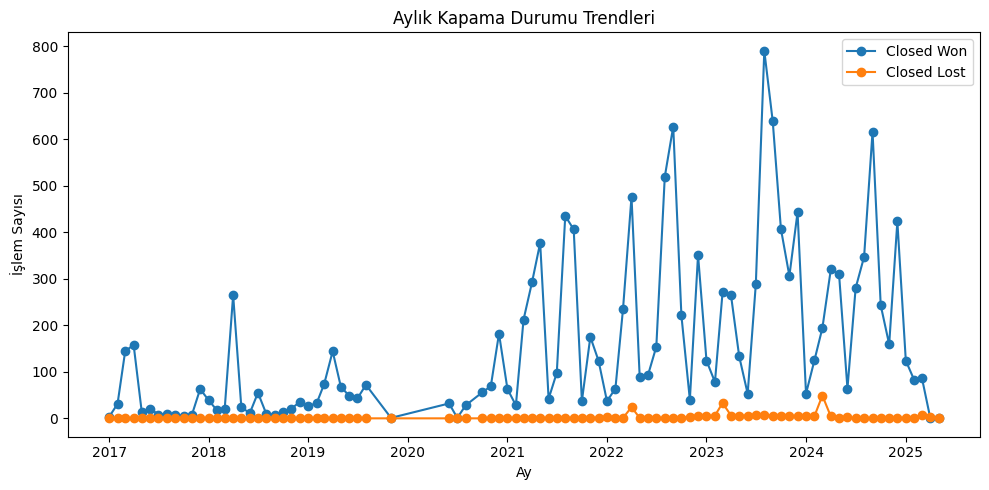

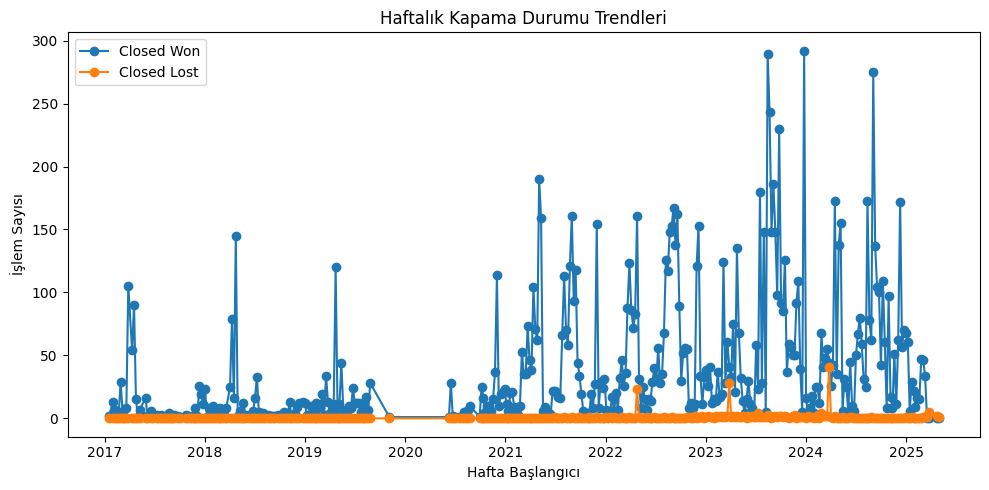

In [32]:
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')
df['stagename'] = df['stagename'].str.strip().str.lower()

# 3. Sadece Closed Won ve Closed Lost kayıtları
df_trend = df[df['stagename'].isin(['closed won', 'closed lost'])].copy()

# 4. Aylık trend hesapla
monthly = (
    df_trend
    .groupby([df_trend['closedate'].dt.to_period('M'), 'stagename'])
    .size()
    .unstack(fill_value=0)
)
monthly.index = monthly.index.to_timestamp()

# 5. Haftalık trend hesapla (Pazartesi başlangıçlı)
weekly = (
    df_trend
    .groupby([df_trend['closedate'].dt.to_period('W-MON'), 'stagename'])
    .size()
    .unstack(fill_value=0)
)
weekly.index = weekly.index.to_timestamp()

# --- Grafik 1: Aylık Kapama Durumları ---
plt.figure(figsize=(10, 5))
plt.plot(monthly.index, monthly['closed won'], marker='o', label='Closed Won')
plt.plot(monthly.index, monthly['closed lost'], marker='o', label='Closed Lost')
plt.title('Aylık Kapama Durumu Trendleri')
plt.xlabel('Ay')
plt.ylabel('İşlem Sayısı')
plt.legend()
plt.tight_layout()
plt.show()

# --- Grafik 2: Haftalık Kapama Durumları ---
plt.figure(figsize=(10, 5))
plt.plot(weekly.index, weekly['closed won'], marker='o', label='Closed Won')
plt.plot(weekly.index, weekly['closed lost'], marker='o', label='Closed Lost')
plt.title('Haftalık Kapama Durumu Trendleri')
plt.xlabel('Hafta Başlangıcı')
plt.ylabel('İşlem Sayısı')
plt.legend()
plt.tight_layout()
plt.show()

In [53]:
# Top 10 platformu satış sayısına göre belirle
top_platforms = (
    platform_campaign
    .groupby('platform__c')['transaction_count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Bu 10 platform için veriyi filtrele
filtered = platform_campaign[platform_campaign['platform__c'].isin(top_platforms)]

# Her platformun en yüksek toplam tutara sahip 3 kampanyası
top_3_by_top_platforms = (
    filtered
    .sort_values(['platform__c', 'total_amount'], ascending=[True, False])
    .groupby('platform__c')
    .head(3)
)

# Platform adına göre sıralama yapmak için sıralı kategorilere dönüştür
top_3_by_top_platforms['platform__c'] = pd.Categorical(
    top_3_by_top_platforms['platform__c'],
    categories=top_platforms,
    ordered=True
)

# Grafik
plt.figure(figsize=(14, 8))
sns.barplot(
    data=top_3_by_top_platforms,
    x='platform__c',
    y='total_amount',
    hue='campaign.name',
    dodge=True
)

plt.title('Top 10 Platformun En Başarılı 3 Kampanyası (Toplam Tutar Bazlı)')
plt.xlabel('Platform')
plt.ylabel('Toplam Satış Tutarı')
plt.xticks(rotation=45)

# Bar etiketleri
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

plt.tight_layout()
plt.savefig("top10_platform_top3_campaign.png", dpi=300)
plt.savefig("top10platform.png", dpi=300)
plt.show()


NameError: name 'platform_campaign' is not defined

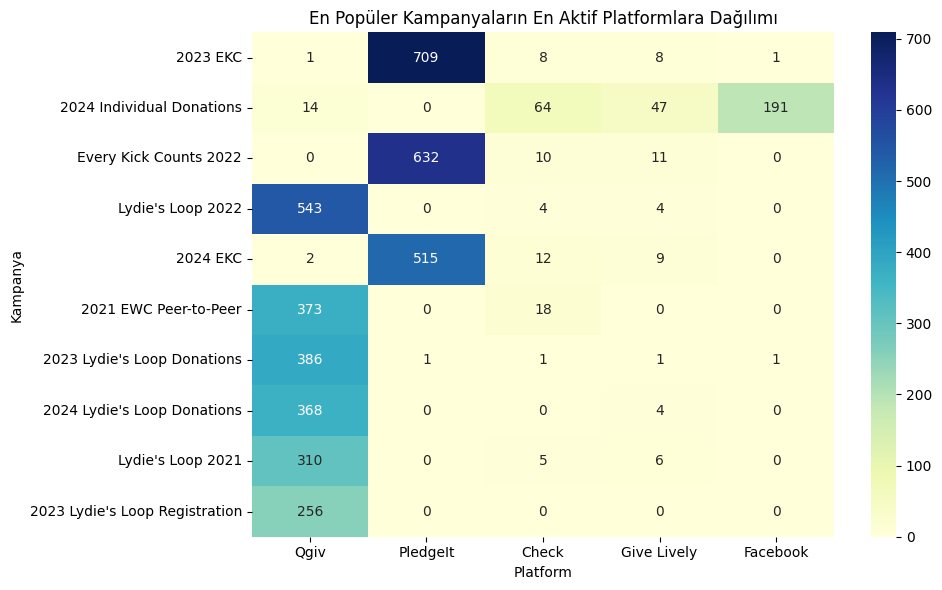

In [50]:
# Kampanyaların platformlara göre dağılımı
campaign_platform_dist = pd.crosstab(df['campaign.name'], df['platform__c'])
campaign_platform_dist['total'] = campaign_platform_dist.sum(axis=1)
campaign_platform_dist = campaign_platform_dist.sort_values('total', ascending=False)

campaign_platform_dist.head()
campaign_platform_dist = campaign_platform_dist.drop('No campaign', axis=0)



# Sadece en çok kullanılan ilk 10 kampanya ve ilk 5 platform
top_campaigns = campaign_platform_dist.head(10).index
top_platforms = campaign_platform_dist.drop('total', axis=1).sum().sort_values(ascending=False).head(5).index

filtered = campaign_platform_dist.loc[top_campaigns, top_platforms]

plt.figure(figsize=(10, 6))
sns.heatmap(filtered, annot=True, fmt='g', cmap='YlGnBu')

plt.title('En Popüler Kampanyaların En Aktif Platformlara Dağılımı')
plt.xlabel("Platform")
plt.ylabel("Kampanya")
plt.tight_layout()
plt.savefig("heatmap.png", dpi=300)
plt.show()


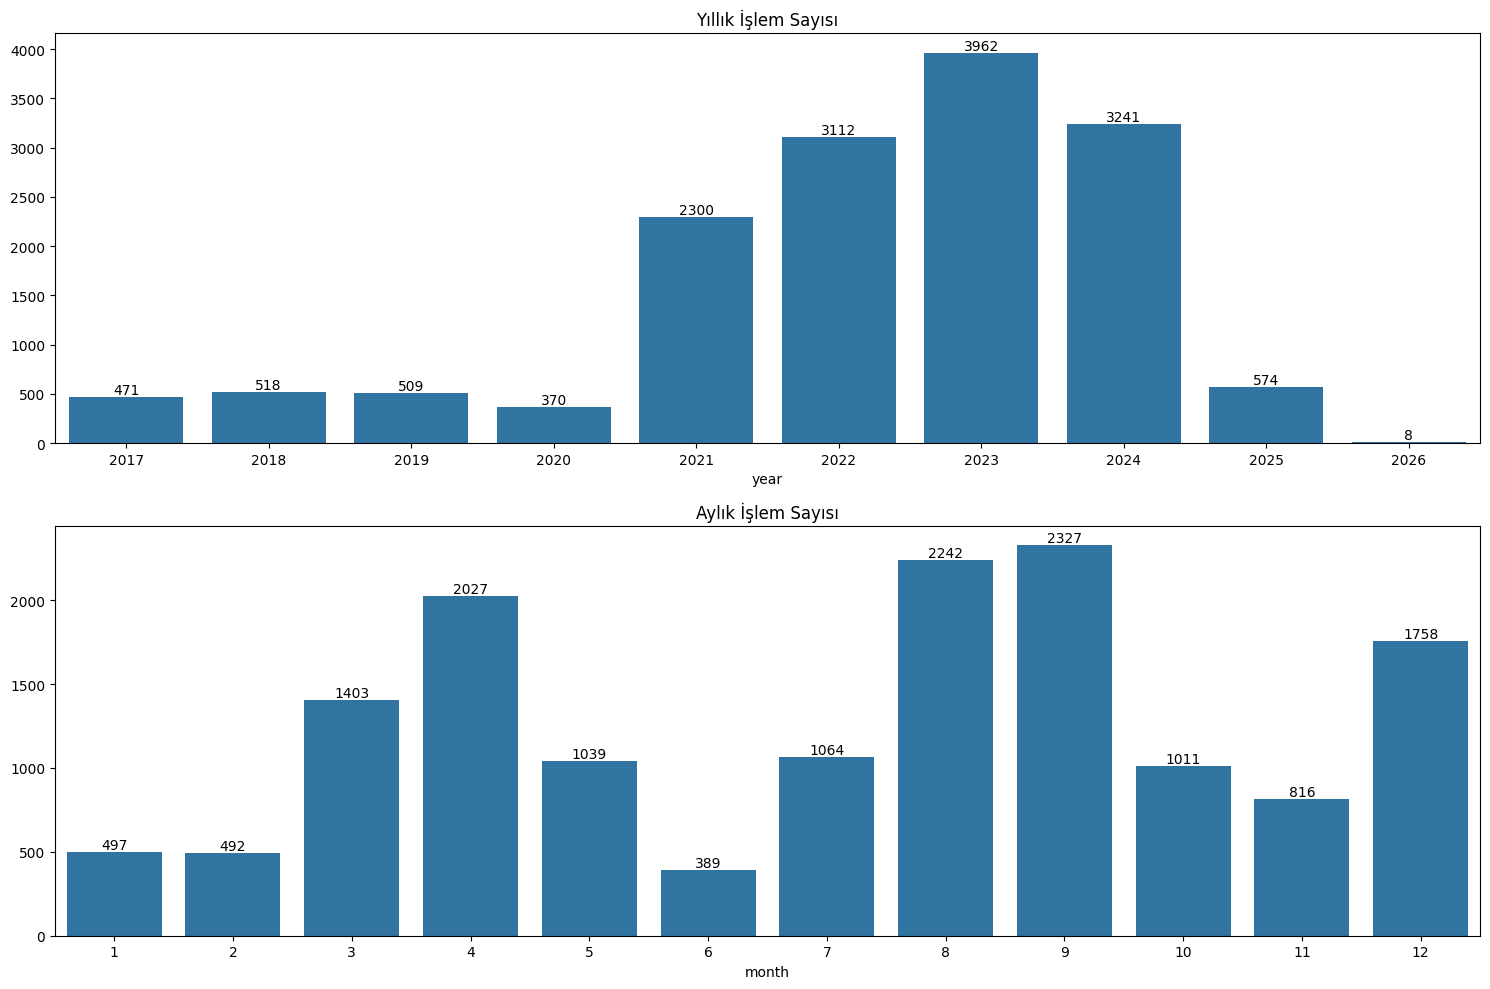

In [35]:
# Yıllık ve aylık işlem sayısı analizi
df['year'] = df['closedate'].dt.year
df['month'] = df['closedate'].dt.month

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Yıllık işlem sayısı
yearly_trans = df.groupby('year').size()
sns.barplot(x=yearly_trans.index, y=yearly_trans.values, ax=ax1)
ax1.set_title('Yıllık İşlem Sayısı')
ax1.bar_label(ax1.containers[0])

# Aylık işlem sayısı
monthly_trans = df.groupby('month').size()
sns.barplot(x=monthly_trans.index, y=monthly_trans.values, ax=ax2)
ax2.set_title('Aylık İşlem Sayısı')
ax2.bar_label(ax2.containers[0])

plt.tight_layout()
plt.savefig("aylıkişlemsutun.png", dpi=300)
plt.show()

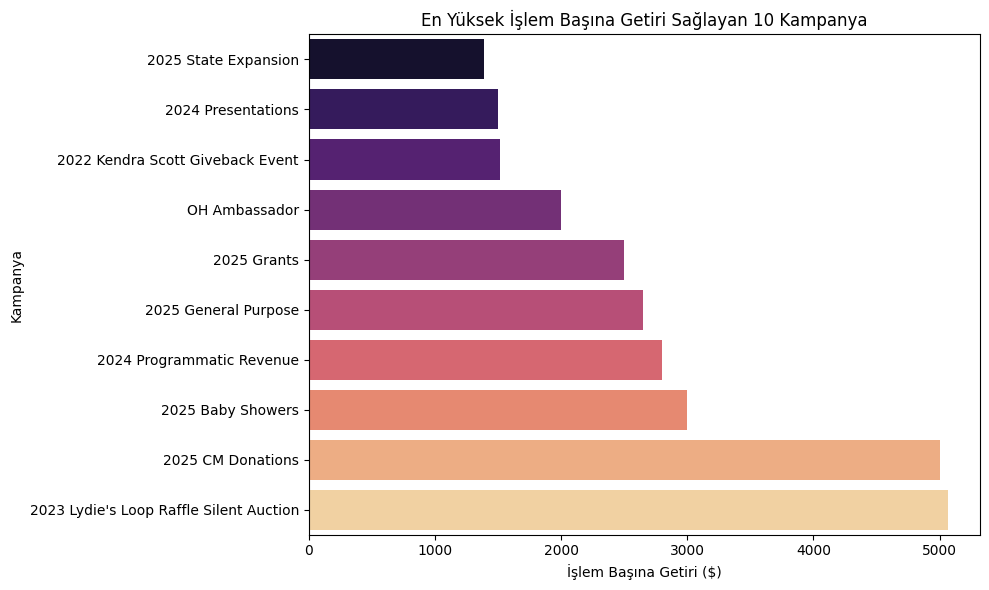


Yüksek Getiri / Düşük Satış Kampanyaları:
                                         transaction_count  total_revenue  \
campaign.name                                                               
2023 Lydie's Loop Raffle Silent Auction                  1        5067.00   
2025 CM Donations                                        1        5000.00   
2025 Baby Showers                                        1        3000.00   
2024 Programmatic Revenue                                5       70050.00   
2025 General Purpose                                     3       23850.00   
2025 Grants                                              1        2500.00   
OH Ambassador                                            1        2000.00   
2022 Kendra Scott Giveback Event                         1        1516.45   
2024 Presentations                                       1        1500.00   
2025 State Expansion                                     2        5550.00   

                                

In [36]:
# Getiri-satış analizi
df['revenue_per_transaction'] = df['amount'] / df.groupby('campaign.name')['amount'].transform('count')

# Az satış yüksek getiri analizi
high_revenue_low_sales = df.groupby('campaign.name').agg({
    'amount': ['count', 'sum'],
    'revenue_per_transaction': 'mean'
}).round(2)

high_revenue_low_sales.columns = ['transaction_count', 'total_revenue', 'revenue_per_transaction']
high_revenue_low_sales = high_revenue_low_sales.sort_values('revenue_per_transaction', ascending=False)

top10 = high_revenue_low_sales.head(10).sort_values('revenue_per_transaction')

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10,
    x='revenue_per_transaction',
    y=top10.index,
    palette='magma'
)

plt.title('En Yüksek İşlem Başına Getiri Sağlayan 10 Kampanya')
plt.xlabel('İşlem Başına Getiri ($)')
plt.ylabel('Kampanya')
plt.tight_layout()
plt.savefig("enyüksekgetiri.png", dpi=300)
plt.show()



print("\nYüksek Getiri / Düşük Satış Kampanyaları:")
print(high_revenue_low_sales.head(10))

In [37]:
# 10 for 10 kampanya analizi
ten_for_ten = df[df['campaign.name'].str.contains('10 for 10', na=False)]
ten_for_ten_platform = ten_for_ten.groupby('platform__c').agg({
    'amount': ['count', 'sum', 'mean'],
    'stagename': lambda x: (x == 'closed won').mean() * 100
}).round(2)

print("\n10 for 10 Kampanya Platform Analizi:")
print(ten_for_ten_platform)


10 for 10 Kampanya Platform Analizi:
            amount                stagename
             count     sum   mean  <lambda>
platform__c                                
Facebook        64  2746.0  42.91     100.0


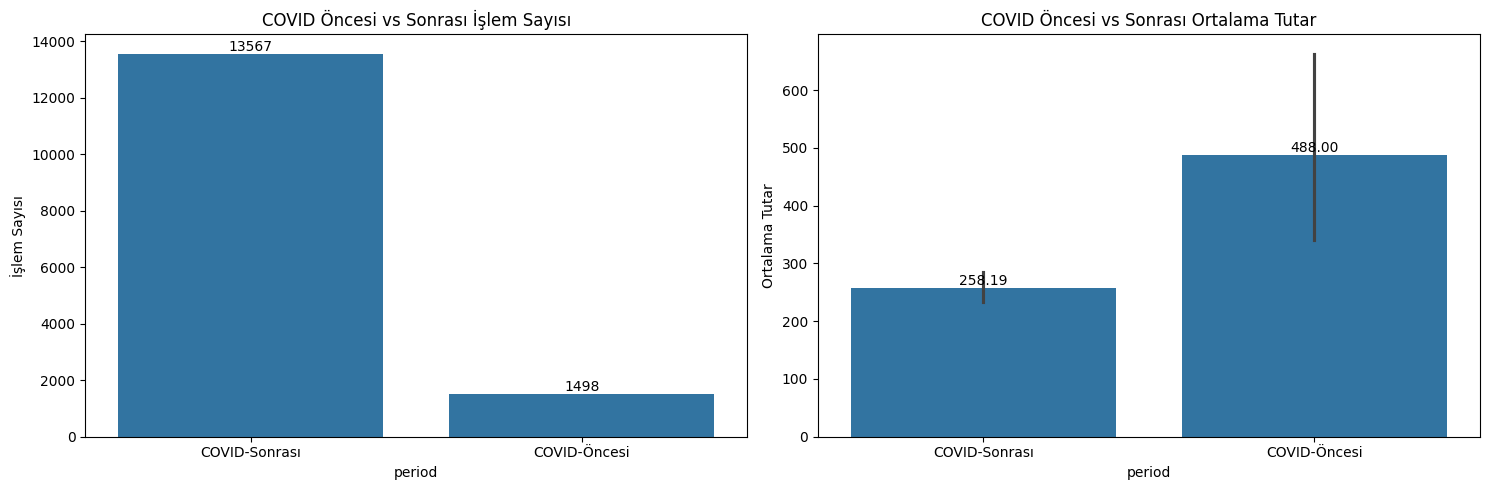

In [38]:
# 1. COVID-19 Öncesi ve Sonrası Analiz (2020 Mart ayı baz alınarak)
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')  # Tarih formatı güvenliği
df['period'] = df['closedate'].apply(lambda x: 'COVID-Öncesi' if x < pd.Timestamp('2020-03-01') else 'COVID-Sonrası')

# COVID öncesi ve sonrası performans karşılaştırması (stagename olmadan)
covid_analysis = df.groupby('period').agg({
    'amount': ['count', 'sum', 'mean']
}).round(2)

covid_analysis.columns = ['transaction_count', 'total_amount', 'avg_amount']


# Görselleştirme
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# ✅ İşlem Sayısı Karşılaştırması (countplot ile)
sns.countplot(data=df, x='period', ax=ax1)
ax1.set_title('COVID Öncesi vs Sonrası İşlem Sayısı')
ax1.set_ylabel('İşlem Sayısı')
ax1.bar_label(ax1.containers[0])

# Ortalama Tutar Karşılaştırması
sns.barplot(data=df, x='period', y='amount', estimator=np.mean, ax=ax2)
ax2.set_title('COVID Öncesi vs Sonrası Ortalama Tutar')
ax2.set_ylabel('Ortalama Tutar')
ax2.bar_label(ax2.containers[0], fmt='%.2f')

plt.tight_layout()
plt.savefig("covid.png", dpi=300)
plt.show()
# toplam tutar da ekle

In [39]:
df.groupby("period").agg({"amount":"sum"})

,amount
period,
COVID-Sonrası,3502909.23
COVID-Öncesi,731027.86


2020 Sonrası Ay Bazında Toplam Benzersiz Kampanya Sayısı:
        month  campaign_count
0     January              35
1    February              41
2       March              53
3       April              51
4         May              38
5        June              23
6        July              47
7      August              50
8   September              44
9     October              43
10   November              38
11   December              36


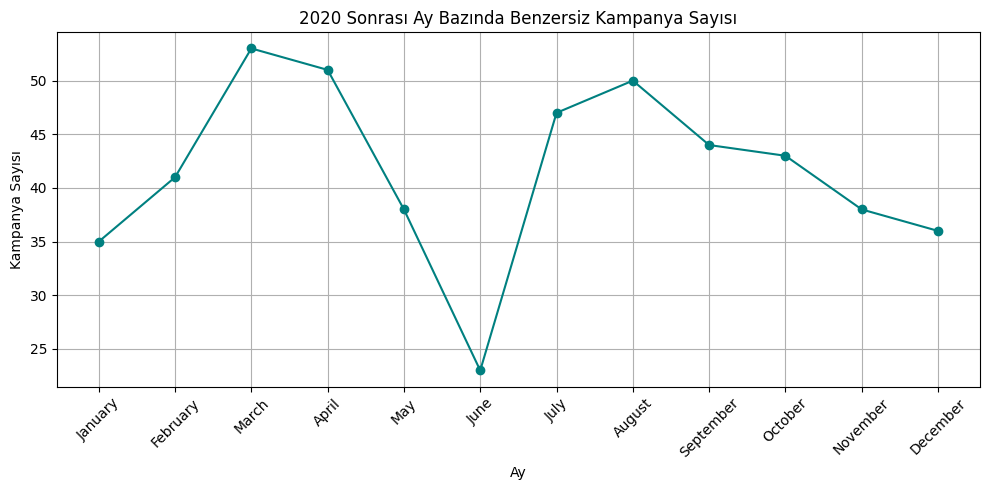

In [43]:
# 1. 'closedate' sütununu datetime formatına çeviriyoruz
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')

# 2. 2020 ve sonrası için filtreleme yapıyoruz
df_post2020 = df[df['closedate'].dt.year >= 2020]

# 3. 'No campaign' olan kayıtları hariç tutuyoruz
df_campaign = df_post2020[df_post2020['campaign.name'] != 'No campaign']

# 4. Ay ismini oluşturuyoruz (örn. January, February, ...)
df_campaign['month'] = df_campaign['closedate'].dt.month_name()

# 5. Her ay için benzersiz kampanya sayısını hesaplıyoruz
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

monthly_campaign_count = (
    df_campaign.groupby('month')['campaign.name']
    .nunique()
    .reindex(month_order)
    .reset_index(name='campaign_count')
)

print("2020 Sonrası Ay Bazında Toplam Benzersiz Kampanya Sayısı:")
print(monthly_campaign_count)

# 6. Sonuçları görselleştiriyoruz
plt.figure(figsize=(10, 5))
plt.plot(monthly_campaign_count['month'],
         monthly_campaign_count['campaign_count'],
         marker='o', linestyle='-', color='teal')
plt.title("2020 Sonrası Ay Bazında Benzersiz Kampanya Sayısı")
plt.xlabel("Ay")
plt.ylabel("Kampanya Sayısı")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("monthly_campaign_count_by_month.png", dpi=300)
plt.show()

Her Platformda Benzersiz Kampanya Sayısı:
                  platform__c  unique_campaigns
0                  32Auctions                 2
1                 Applied Art                 3
2                    Benevity                 5
3                 CTK Website                36
4                        Cash                 9
5                       Check                98
6        Community Foundation                24
7   Cybergrants - CAF America                 4
8    Cybergrants - Nationwide                 1
9              Direct Deposit                25
10                   Facebook                15
11                Frontstream                 2
12                   FundEasy                33
13                Give Lively                55
14                   Grateful                 1
15                HBD Website                14
16                  Instagram                 5
17                 Pledge.com                 1
18                   PledgeIt                1

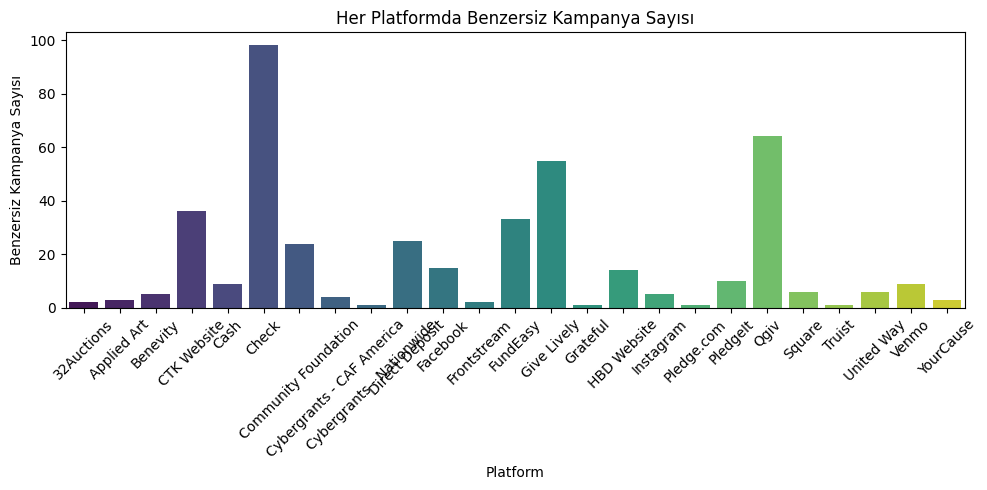

In [52]:
# 1. 'No campaign' kayıtlarını hariç tutarak kampanya verilerini filtreleyin
df_campaign = df[df['campaign.name'] != 'No campaign']

# 2. Her platform için benzersiz kampanya sayısını hesaplayın
platform_campaign_count = (
    df_campaign.groupby('platform__c')['campaign.name']
    .nunique()
    .reset_index(name='unique_campaigns')
)

print("Her Platformda Benzersiz Kampanya Sayısı:")
print(platform_campaign_count)

# 3. Sonuçları görselleştirin
plt.figure(figsize=(10, 5))
sns.barplot(data=platform_campaign_count,
            x='platform__c',
            y='unique_campaigns',
            palette='viridis')
plt.title("Her Platformda Benzersiz Kampanya Sayısı")
plt.xlabel("Platform")
plt.ylabel("Benzersiz Kampanya Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("platform_unique_campaigns.png", dpi=300)
plt.show()

Her Platformda Benzersiz Kullanıcı Sayısı:
                  platform__c  unique_users
19                       Qgiv          3456
18                   PledgeIt          1592
10                   Facebook          1480
5                       Check           651
3                 CTK Website           614
13                Give Lively           603
12                   FundEasy           549
15                HBD Website           154
1                 Applied Art           148
23                      Venmo           107
20                     Square            83
9              Direct Deposit            73
0                  32Auctions            55
2                    Benevity            51
16                  Instagram            46
22                 United Way            25
6        Community Foundation            24
17                 Pledge.com            13
4                        Cash            11
7   Cybergrants - CAF America             9
11                Frontstream    

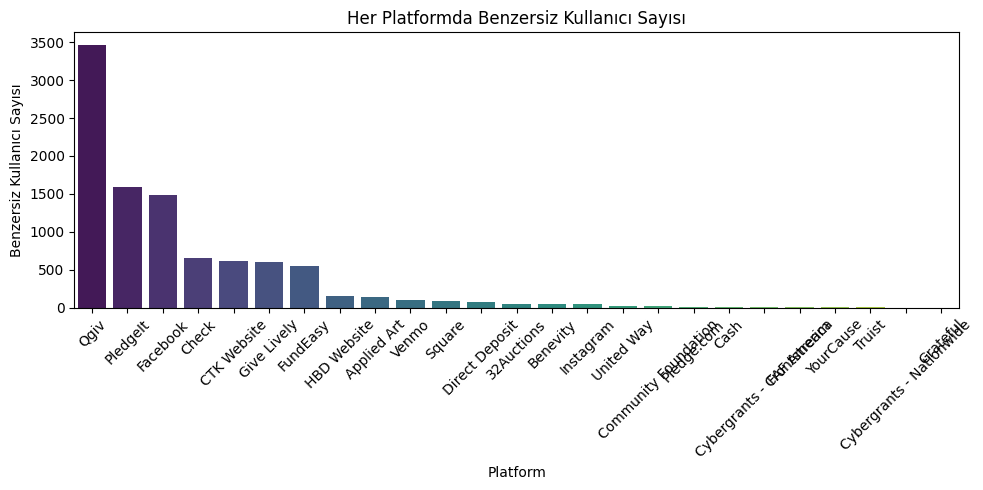

In [48]:
# Her platform için benzersiz kullanıcı sayısını hesaplayın (örneğin: 'contactid' kullanılıyor)
unique_user_count = (
    df.groupby('platform__c')['contactid']
      .nunique()
      .reset_index(name='unique_users')
)
unique_user_count = unique_user_count.sort_values(by="unique_users", ascending=False)
print("Her Platformda Benzersiz Kullanıcı Sayısı:")
print(unique_user_count)

# Sonuçları görselleştirin
plt.figure(figsize=(10, 5))
sns.barplot(data=unique_user_count,
            x='platform__c',
            y='unique_users',
            palette='viridis')
plt.title("Her Platformda Benzersiz Kullanıcı Sayısı")
plt.xlabel("Platform")
plt.ylabel("Benzersiz Kullanıcı Sayısı")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("platform_unique_users.png", dpi=300)
plt.show()

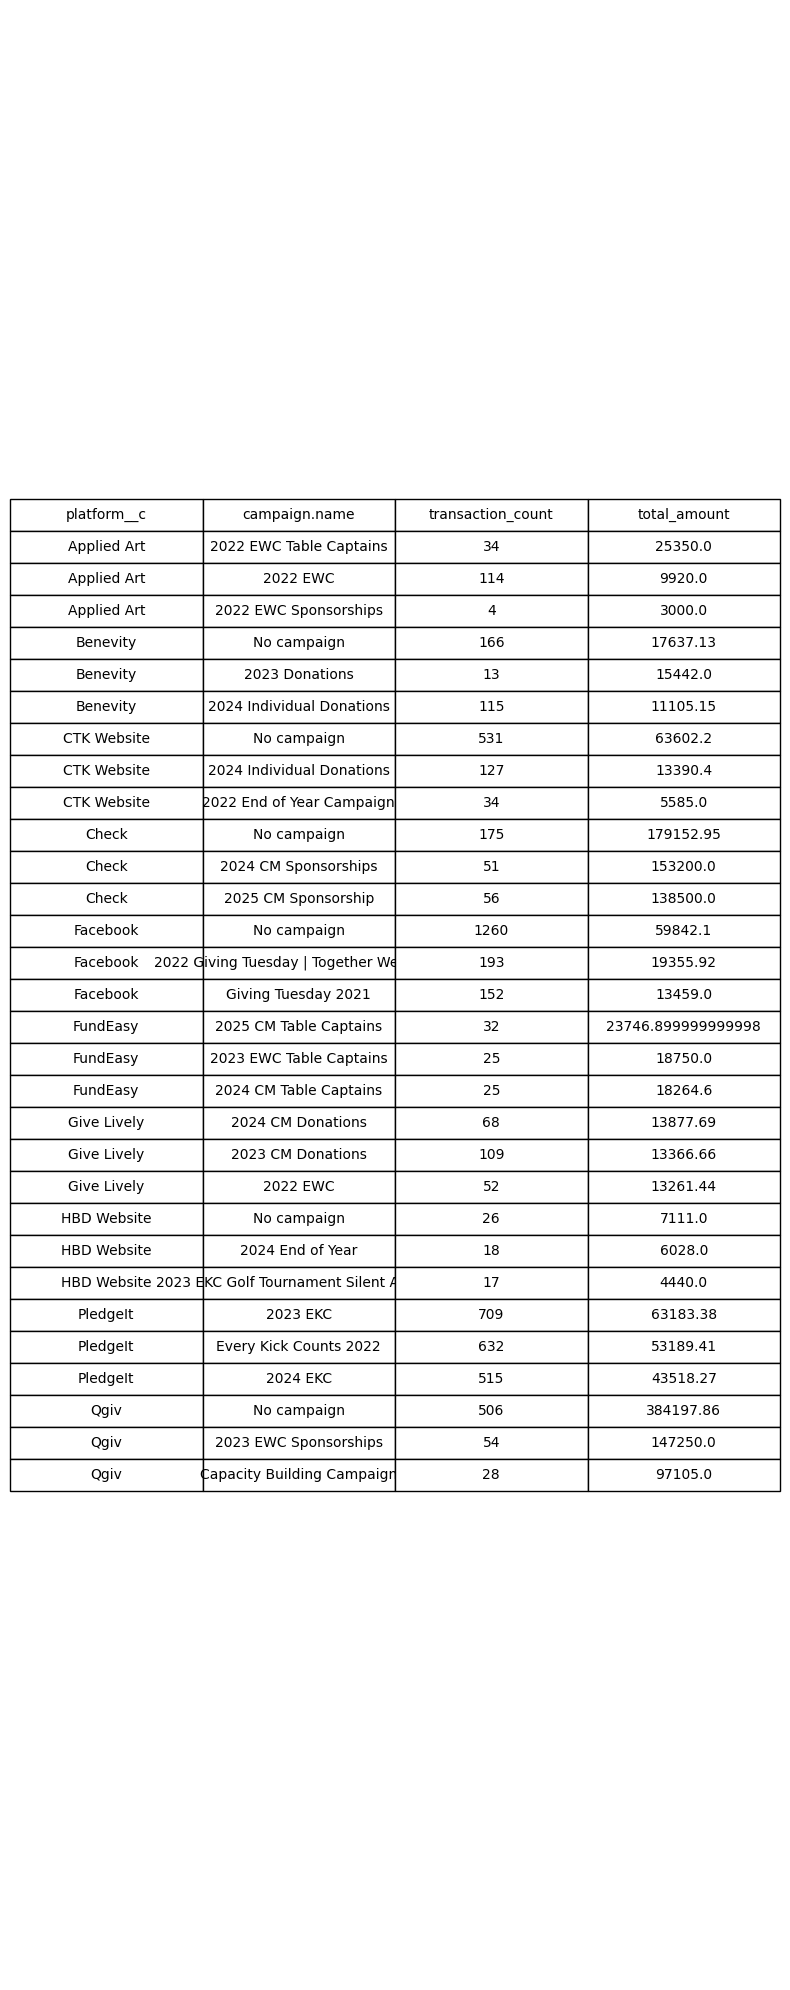

In [58]:
import matplotlib.pyplot as plt

# DataFrame'in boyutuna göre uyarlanabilir şekilde figür boyutunu ayarlıyoruz
n_rows = len(top_3_by_top_platforms)
fig, ax = plt.subplots(figsize=(top_3_by_top_platforms.shape[1]*2, n_rows*0.6 + 2))

# Eksenleri kapatıyoruz
ax.axis('tight')
ax.axis('off')

# Tabloyu oluşturuyoruz
table = ax.table(cellText=top_3_by_top_platforms.values,
                 colLabels=top_3_by_top_platforms.columns,
                 cellLoc='center',
                 loc='center')

# Yazı boyutunu ayarlama (isteğe bağlı)
table.auto_set_font_size(False)
table.set_fontsize(10)

# Sütun genişliklerini ayarlamak için
table.scale(1, 1.5)

plt.tight_layout()
plt.savefig("top_3_platforms_table.png", dpi=300)
plt.show()

Top 10 Kampanya - İşlem Adedi:
                      campaign.name  transaction_count
41                         2023 EKC                738
93        2024 Individual Donations                697
142          Every Kick Counts 2022                662
149               Lydie's Loop 2022                551
83                         2024 EKC                544
14            2021 EWC Peer-to-Peer                394
54      2023 Lydie's Loop Donations                392
100     2024 Lydie's Loop Donations                373
148               Lydie's Loop 2021                349
56   2023 Lydie's Loop Registration                256


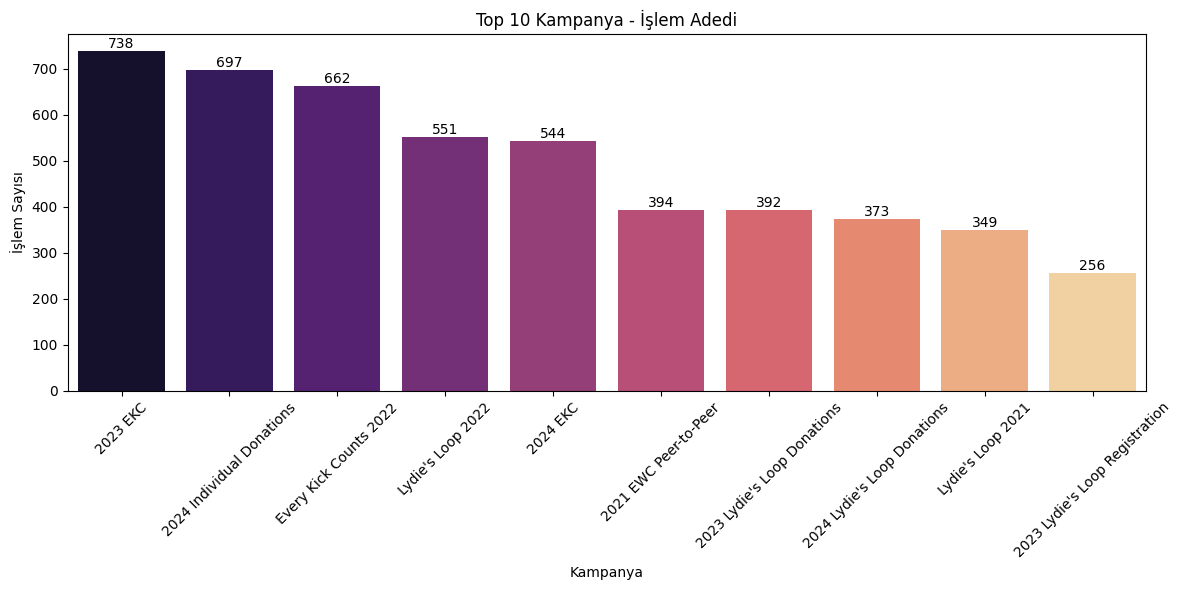

In [64]:
# "No campaign" kayıtlarını hariç tutarak kampanya verilerini filtreleyelim
df_campaign = df[df['campaign.name'] != 'No campaign']

# Her kampanya için işlem adedini hesaplayalım (örneğin: 'contactid' üzerinden)
campaign_transaction = (
    df_campaign.groupby('campaign.name')['contactid']
    .count()
    .reset_index(name='transaction_count')
)

# İşlem adetlerine göre azalan sıralayalım ve ilk 10 kampanyayı seçelim
top10_campaign_transaction = campaign_transaction.sort_values('transaction_count', ascending=False).head(10)

print("Top 10 Kampanya - İşlem Adedi:")
print(top10_campaign_transaction)

# Bar grafiği ile sonuçları görselleştirelim ve barların üstüne label ekleyelim
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=top10_campaign_transaction, x='campaign.name', y='transaction_count', palette='magma')
plt.title("Top 10 Kampanya - İşlem Adedi")
plt.xlabel("Kampanya")
plt.ylabel("İşlem Sayısı")
plt.xticks(rotation=45)

# Barların üstüne değer etiketlerini ekleyelim
for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=10)

plt.tight_layout()
plt.savefig("top10_campaign_transaction_count.png", dpi=300)
plt.show()

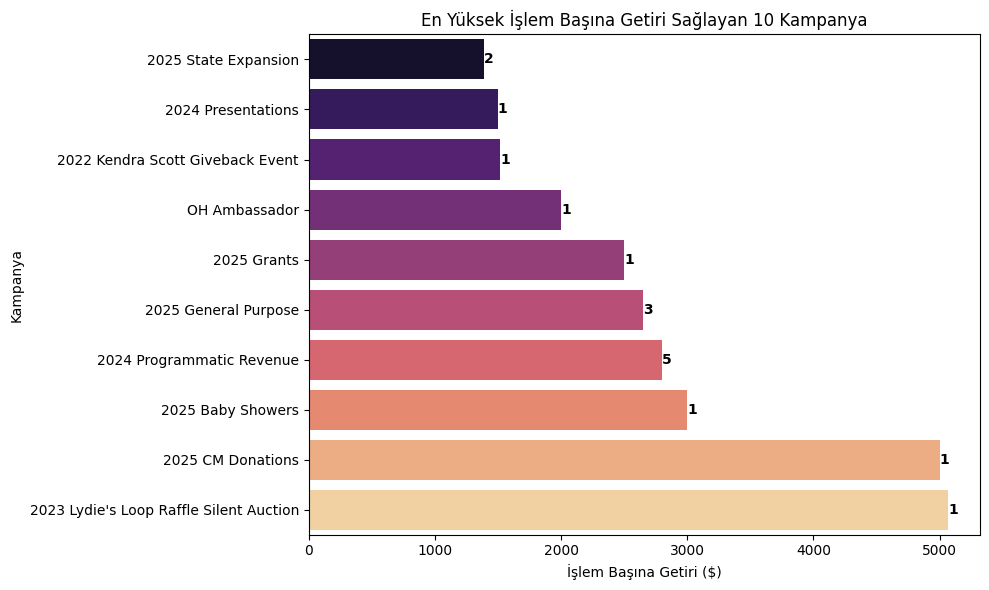


Yüksek Getiri / Düşük Satış Kampanyaları:
                                         transaction_count  total_revenue  \
campaign.name                                                               
2023 Lydie's Loop Raffle Silent Auction                  1        5067.00   
2025 CM Donations                                        1        5000.00   
2025 Baby Showers                                        1        3000.00   
2024 Programmatic Revenue                                5       70050.00   
2025 General Purpose                                     3       23850.00   
2025 Grants                                              1        2500.00   
OH Ambassador                                            1        2000.00   
2022 Kendra Scott Giveback Event                         1        1516.45   
2024 Presentations                                       1        1500.00   
2025 State Expansion                                     2        5550.00   

                                

In [62]:
# Kampanyaların getiri-satış analizi: Her kampanyanın işlem başına getirisini ve kullanım sayısını hesaplıyoruz
df['revenue_per_transaction'] = df['amount'] / df.groupby('campaign.name')['amount'].transform('count')

high_revenue_low_sales = df.groupby('campaign.name').agg({
    'amount': ['count', 'sum'],
    'revenue_per_transaction': 'mean'
}).round(2)

# Kolon isimlerini sadeleştiriyoruz
high_revenue_low_sales.columns = ['transaction_count', 'total_revenue', 'revenue_per_transaction']

# En yüksek getiriye göre sıralıyoruz
high_revenue_low_sales = high_revenue_low_sales.sort_values('revenue_per_transaction', ascending=False)

# İlk 10 kampanyayı seçip, getiri başına getiriye göre artan sıraya diziyoruz
top10 = high_revenue_low_sales.head(10).sort_values('revenue_per_transaction')

# Bar grafiği oluşturuyoruz
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=top10,
    x='revenue_per_transaction',
    y=top10.index,
    palette='magma'
)

plt.title('En Yüksek İşlem Başına Getiri Sağlayan 10 Kampanya')
plt.xlabel('İşlem Başına Getiri ($)')
plt.ylabel('Kampanya')

# Her barın üzerine kampanyanın kullanım sayısını ekleyelim
for i, patch in enumerate(ax.patches):
    width = patch.get_width()
    campaign = top10.index[i]
    trans_count = top10.loc[campaign, 'transaction_count']
    ax.text(width + 0.05,
            patch.get_y() + patch.get_height() / 2,
            f"{trans_count}",
            fontweight='bold', color='black', va='center')

plt.tight_layout()
plt.savefig("enyuksekgetiri_with_usage.png", dpi=300)
plt.show()

print("\nYüksek Getiri / Düşük Satış Kampanyaları:")
print(high_revenue_low_sales.head(10))

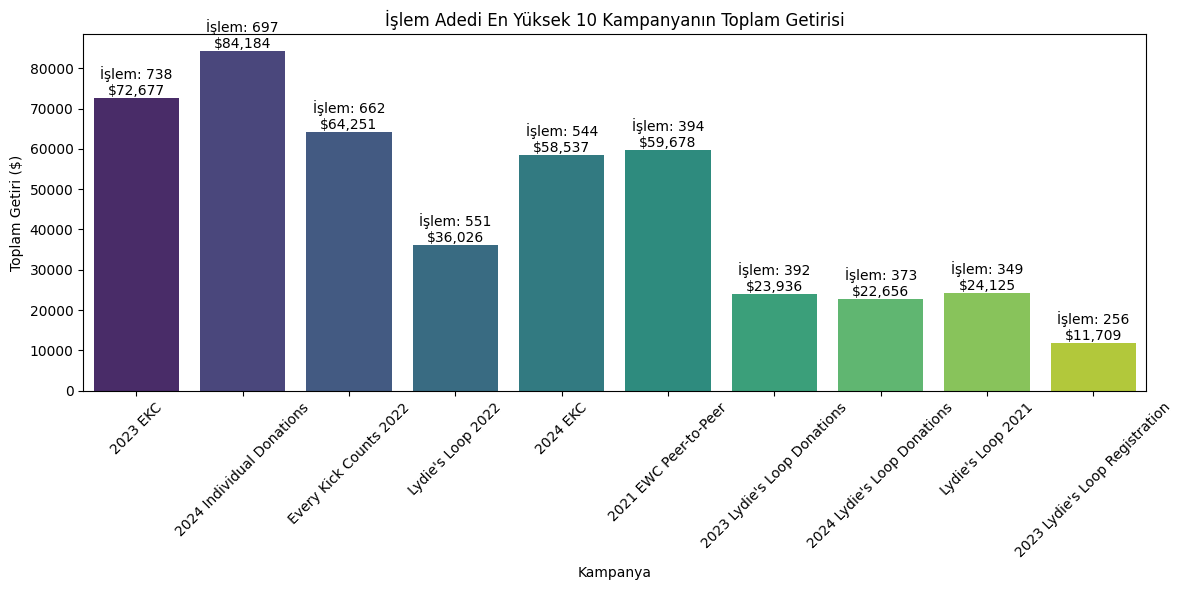


Top 10 Kampanya Detayları:
                 campaign.name  transaction_count  total_revenue
                      2023 EKC                738       72676.70
     2024 Individual Donations                697       84183.71
        Every Kick Counts 2022                662       64250.91
             Lydie's Loop 2022                551       36026.50
                      2024 EKC                544       58536.89
         2021 EWC Peer-to-Peer                394       59678.25
   2023 Lydie's Loop Donations                392       23936.15
   2024 Lydie's Loop Donations                373       22656.06
             Lydie's Loop 2021                349       24124.60
2023 Lydie's Loop Registration                256       11708.70


In [66]:
# "No campaign" kayıtlarını hariç tutarak kampanya verilerini filtreleyelim
df_campaign = df[df['campaign.name'] != 'No campaign']

# Her kampanya için işlem adedi ve toplam getiriyi hesaplayalım
campaign_analysis = df_campaign.groupby('campaign.name').agg({
    'contactid': 'count',  # işlem adedi
    'amount': 'sum'       # toplam getiri
}).reset_index()

# Kolon isimlerini düzenleyelim
campaign_analysis.columns = ['campaign.name', 'transaction_count', 'total_revenue']

# İşlem adedine göre ilk 10 kampanyayı seçelim
top10_campaigns = campaign_analysis.nlargest(10, 'transaction_count')

# Bar grafiği oluşturalım
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    data=top10_campaigns,
    x='campaign.name',
    y='total_revenue',
    palette='viridis'
)

plt.title('İşlem Adedi En Yüksek 10 Kampanyanın Toplam Getirisi')
plt.xlabel('Kampanya')
plt.ylabel('Toplam Getiri ($)')
plt.xticks(rotation=45)

# Barların üzerine hem işlem adedi hem de getiri bilgisini ekleyelim
for i, row in enumerate(top10_campaigns.itertuples()):
    ax.text(i, row.total_revenue, 
            f'İşlem: {row.transaction_count}\n${row.total_revenue:,.0f}',
            ha='center', va='bottom')

plt.tight_layout()
plt.savefig("top10_campaign_revenue.png", dpi=300)
plt.show()

# Detaylı bilgileri tablo olarak gösterelim
print("\nTop 10 Kampanya Detayları:")
print(top10_campaigns.to_string(index=False))

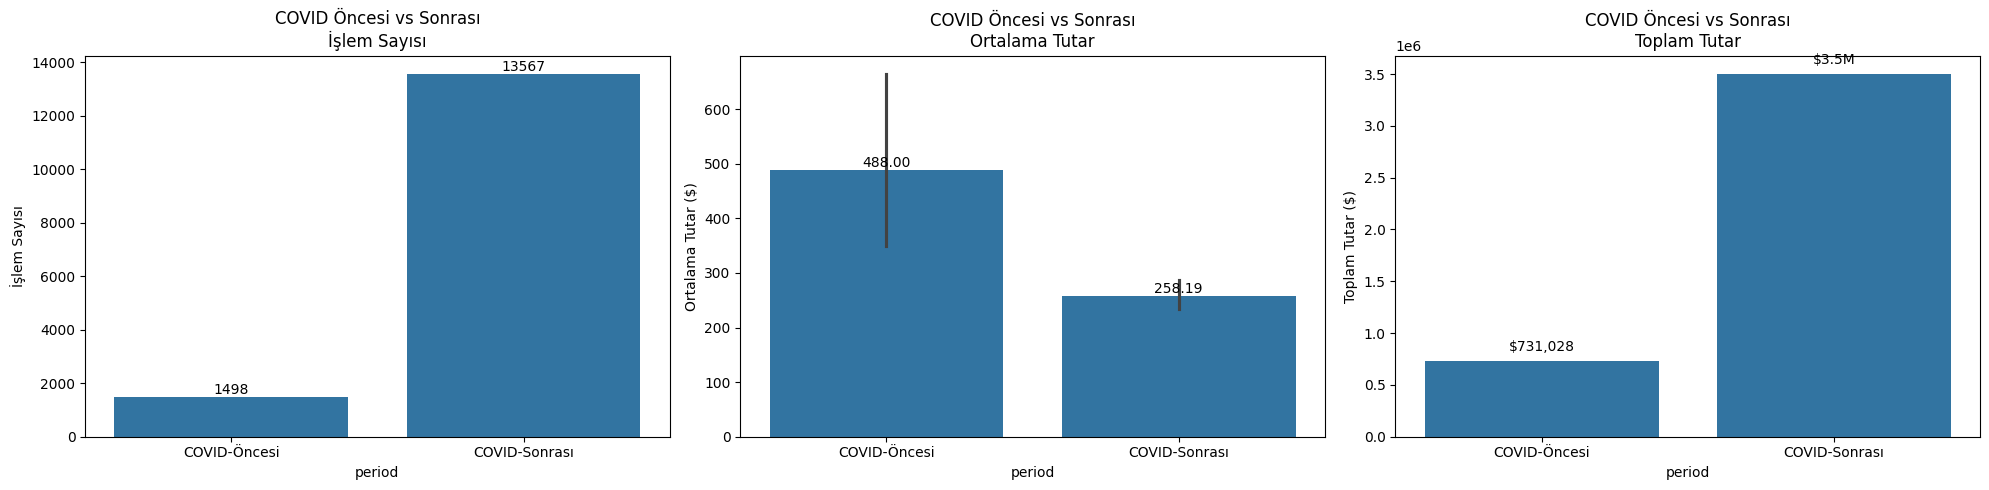


COVID Analizi Detayları:
               transaction_count  total_amount  avg_amount
period                                                    
COVID-Sonrası              13567    3502909.23      258.19
COVID-Öncesi                1498     731027.86      488.00


In [69]:
# 1. COVID-19 Öncesi ve Sonrası Analiz (2020 Mart ayı baz alınarak)
df['closedate'] = pd.to_datetime(df['closedate'], errors='coerce')
df['period'] = df['closedate'].apply(lambda x: 'COVID-Öncesi' if x < pd.Timestamp('2020-03-01') else 'COVID-Sonrası')

# COVID öncesi ve sonrası performans karşılaştırması
covid_analysis = df.groupby('period').agg({
    'amount': ['count', 'sum', 'mean']
}).round(2)

covid_analysis.columns = ['transaction_count', 'total_amount', 'avg_amount']

# Görselleştirme - 3 grafik yan yana
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))

# Sıralama için dönem listesi oluştur
period_order = ['COVID-Öncesi', 'COVID-Sonrası']

# 1. İşlem Sayısı Karşılaştırması
sns.countplot(data=df, x='period', ax=ax1, order=period_order)
ax1.set_title('COVID Öncesi vs Sonrası\nİşlem Sayısı')
ax1.set_ylabel('İşlem Sayısı')
ax1.bar_label(ax1.containers[0])

# 2. Ortalama Tutar Karşılaştırması
sns.barplot(data=df, x='period', y='amount', estimator=np.mean, ax=ax2, order=period_order)
ax2.set_title('COVID Öncesi vs Sonrası\nOrtalama Tutar')
ax2.set_ylabel('Ortalama Tutar ($)')
ax2.bar_label(ax2.containers[0], fmt='%.2f')

# 3. Toplam Tutar Karşılaştırması
period_totals = df.groupby('period')['amount'].sum()
sns.barplot(x=period_totals.index, y=period_totals.values, ax=ax3, order=period_order)
ax3.set_title('COVID Öncesi vs Sonrası\nToplam Tutar')
ax3.set_ylabel('Toplam Tutar ($)')

# Milyon/Milyar formatında etiketleri ekleyelim
def format_amount(x):
    if x >= 1e9:  # Milyar için
        return f'${x/1e9:.1f}B'
    elif x >= 1e6:  # Milyon için
        return f'${x/1e6:.1f}M'
    else:
        return f'${x:,.0f}'

ax3.bar_label(ax3.containers[0], 
              labels=[format_amount(x) for x in period_totals[period_order].values],
              padding=5)

plt.tight_layout()
plt.savefig("covid_analysis_complete.png", dpi=300)
plt.show()

# Detaylı analiz sonuçlarını yazdıralım
print("\nCOVID Analizi Detayları:")
print(covid_analysis)

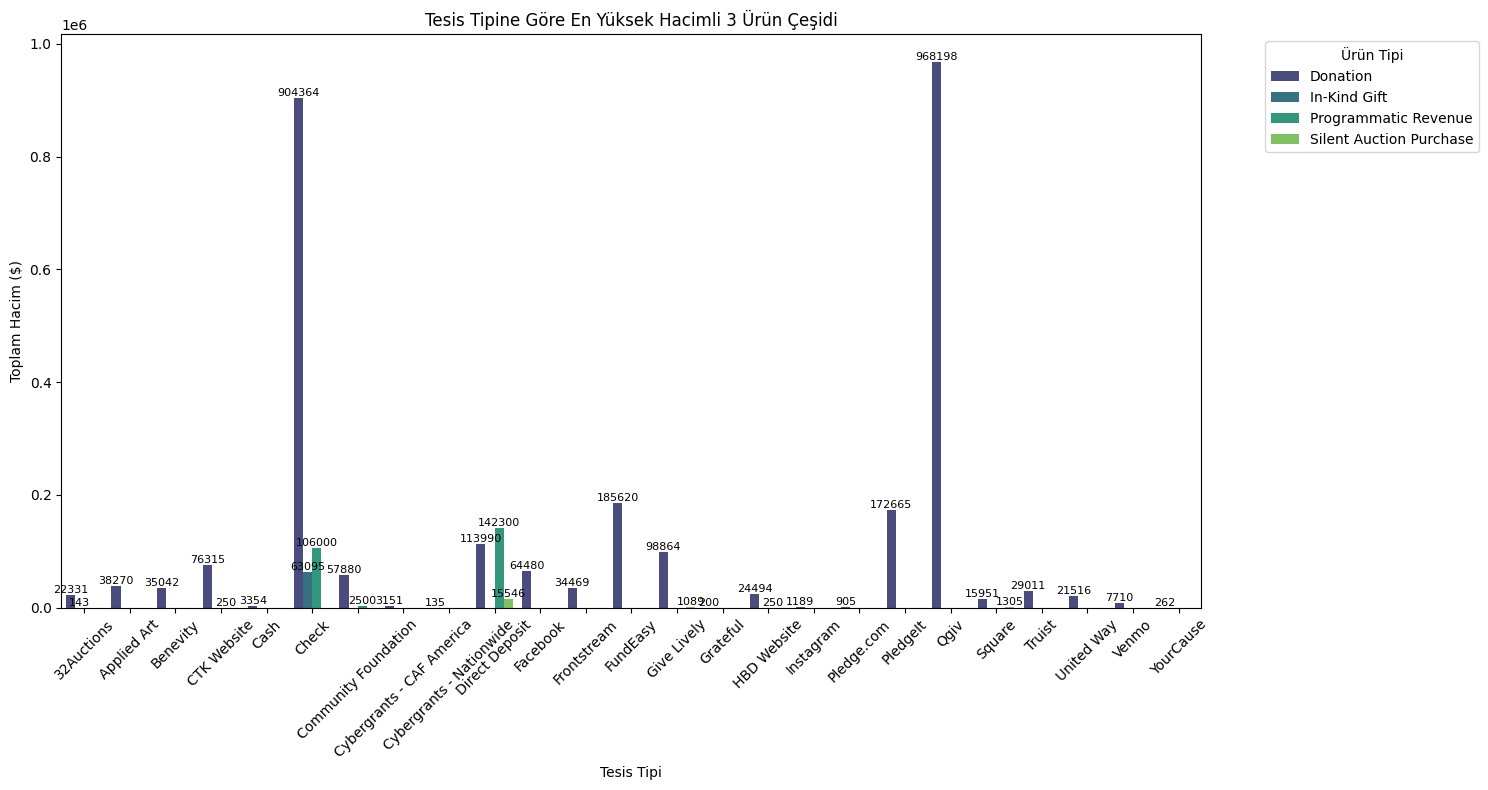


Tesis Tipine Göre En Yüksek Hacimli Ürün Çeşitleri:
              platform__c         recordtype.name  transaction_count  total_amount
                     Qgiv                Donation               4975     968198.29
                    Check                Donation                899     904364.05
                 FundEasy                Donation                740     185619.65
                 PledgeIt                Donation               1978     172665.16
           Direct Deposit    Programmatic Revenue                 13     142300.00
           Direct Deposit                Donation                 54     113990.18
                    Check    Programmatic Revenue                 34     106000.00
              Give Lively                Donation                865      98863.92
              CTK Website                Donation                411      76315.10
                 Facebook                Donation                846      64480.14
                    Check         

In [72]:
# "No campaign" kayıtlarını hariç tutarak filtreleme yapalım
df_filtered = df[df['campaign.name'] != 'No campaign']

# Tesis tipi ve ürün tipi bazlı toplam işlem hacmini hesaplayalım
platform_product_volume = (
    df_filtered.groupby(['platform__c', 'recordtype.name']).agg({
        'amount': ['count', 'sum']  # İşlem sayısı ve toplam tutar
    }).round(2)
)

# Kolon isimlerini düzenleyelim
platform_product_volume.columns = ['transaction_count', 'total_amount']
platform_product_volume = platform_product_volume.reset_index()

# Her tesis tipi için en yüksek hacimli ilk 3 ürün tipini seçelim
top_products_by_platform = (
    platform_product_volume
    .sort_values(['platform__c', 'total_amount'], ascending=[True, False])
    .groupby('platform__c')
    .head(3)
)

# Görselleştirme
plt.figure(figsize=(15, 8))
ax = sns.barplot(
    data=top_products_by_platform,
    x='platform__c',
    y='total_amount',
    hue='recordtype.name',
    palette='viridis'
)

plt.title('Tesis Tipine Göre En Yüksek Hacimli 3 Ürün Çeşidi')
plt.xlabel('Tesis Tipi')
plt.ylabel('Toplam Hacim ($)')
plt.xticks(rotation=45)

# Bar etiketlerini ekleyelim
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge', fontsize=8)

plt.legend(title='Ürün Tipi', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("platform_top_products.png", dpi=300, bbox_inches='tight')
plt.show()

# Detaylı analiz sonuçlarını tablo olarak gösterelim
print("\nTesis Tipine Göre En Yüksek Hacimli Ürün Çeşitleri:")
print(top_products_by_platform.sort_values('total_amount', ascending=False).to_string(index=False))